# Imports

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'sample_submission_stg2.csv', 'additional_Type_3_v2', 'test_stg2.7z', 'fixed_labels_v2.csv', 'solution_stg1_release.csv', 'additional_Type_1_v2', 'test_stg2_7z_password.txt', 'additional_Type_2_v2', 'test', 'train', 'removed_files.csv']


In [21]:
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter

import cv2
from concurrent import futures
import threading

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import datetime

# Data import

In [22]:
#getting the total number of images in the training set

base_dir = '../input'

train_dir = os.path.join(base_dir,'train', 'train')

type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(base_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(base_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(base_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = type1_files + added_type1_files
type2_files = type2_files + added_type2_files
type3_files = type3_files + added_type3_files


print('Number of images in a train set of type 1: ', len(type1_files))
print('Number of images in a train set of type 2: ', len(type2_files))
print('Number of images in a train set of type 3: ', len(type3_files))
print('Total number of images in a train set: ', sum([len(type1_files), len(type2_files), len(type3_files)]))

Number of images in a train set of type 1:  1191
Number of images in a train set of type 2:  3567
Number of images in a train set of type 3:  1976
Total number of images in a train set:  6734


In [23]:
#Building a dataframe mapping images and Cancer type

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
})

files_df

,filename,label
0,../input/additional_Type_1_v2/Type_1/6241.jpg,Type_1
1,../input/additional_Type_1_v2/Type_1/623.jpg,Type_1
2,../input/additional_Type_1_v2/Type_1/2193.jpg,Type_1
3,../input/additional_Type_1_v2/Type_1/2008.jpg,Type_1
4,../input/additional_Type_1_v2/Type_1/5982.jpg,Type_1
...,...,...
6729,../input/additional_Type_3_v2/Type_3/5005.jpg,Type_3
6730,../input/additional_Type_3_v2/Type_3/4463.jpg,Type_3
6731,../input/additional_Type_3_v2/Type_3/5303.jpg,Type_3
6732,../input/additional_Type_3_v2/Type_3/6119.jpg,Type_3


In [24]:
#Shuffle data

random_state = 42

files_df = files_df.sample(frac=1, random_state=random_state)

files_df

,filename,label
381,../input/additional_Type_1_v2/Type_1/1518.jpg,Type_1
4696,../input/additional_Type_2_v2/Type_2/1698.jpg,Type_2
5577,../input/additional_Type_3_v2/Type_3/4435.jpg,Type_3
2018,../input/additional_Type_2_v2/Type_2/4915.jpg,Type_2
2185,../input/additional_Type_2_v2/Type_2/1335.jpg,Type_2
...,...,...
3772,../input/additional_Type_2_v2/Type_2/1182.jpg,Type_2
5191,../input/additional_Type_3_v2/Type_3/1912.jpg,Type_3
5226,../input/additional_Type_3_v2/Type_3/5572.jpg,Type_3
5390,../input/additional_Type_3_v2/Type_3/5508.jpg,Type_3


# Data exploration

In [25]:
files_df.describe()

,filename,label
count,6734,6734
unique,6734,3
top,../input/additional_Type_1_v2/Type_1/1518.jpg,Type_2
freq,1,3567


In [26]:
#Check for duplicates
len(files_df[files_df.duplicated()])

0

In [27]:
#Get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type_2,3567
Type_3,1976
Type_1,1191


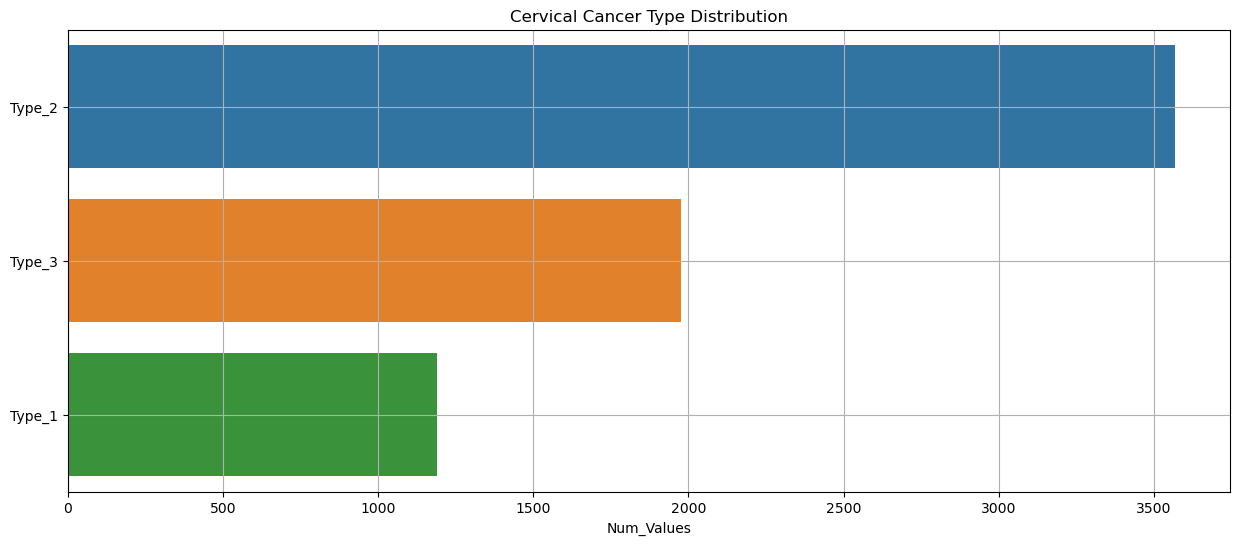

In [28]:
#Display barplot of type count
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Cervical Cancer Type Distribution')
plt.grid(True)
plt.show()

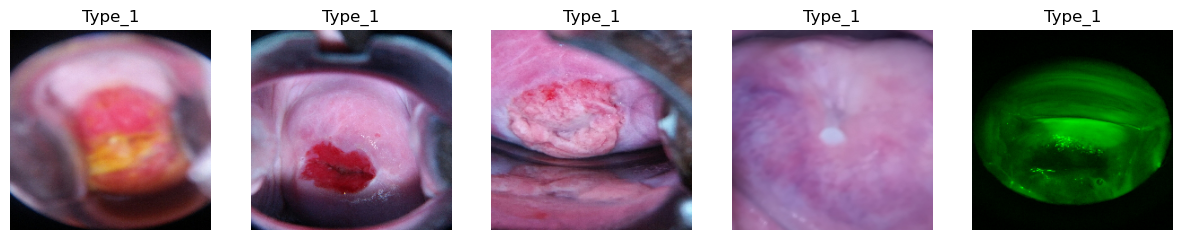

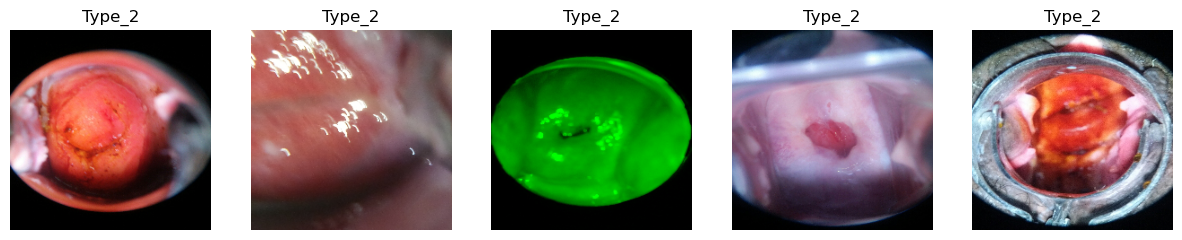

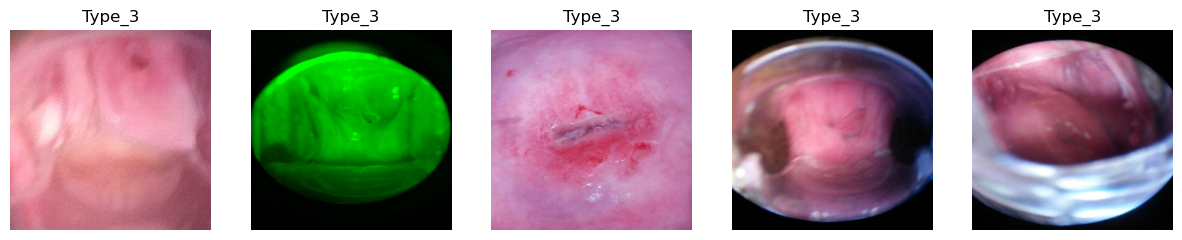

In [29]:
#Display sample images of types
for label in ('Type_1', 'Type_2', 'Type_3'):
    filepaths = files_df[files_df['label']==label]['filename'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

# Data propocessing

In [30]:
#Split training,val and test set : 70:15:15

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, 
                                                                      random_state=random_state)

test_files, val_files, test_labels, val_labels = train_test_split(test_files,
                                                                  test_labels, 
                                                                  test_size=0.5, 
                                                                  random_state=random_state)


print('Number of images in train set: ', train_files.shape)
print('Number of images in validation set: ', val_files.shape)
print('Number of images in test set: ', test_files.shape, '\n')

print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Number of images in train set:  (4713,)
Number of images in validation set:  (1011,)
Number of images in test set:  (1010,) 

Train: Counter({'Type_2': 2532, 'Type_3': 1339, 'Type_1': 842}) 
Val: Counter({'Type_2': 529, 'Type_3': 321, 'Type_1': 161}) 
Test: Counter({'Type_2': 506, 'Type_3': 316, 'Type_1': 188})


In [33]:
def load_images(files, labels):
    features = []
    correct_labels = []
    bad_images = 0
    
    for i in range(len(files)):
        try:
            img = cv2.imread(files[i])
#             print("Read image.")
            resized_img = cv2.resize(img, (160, 160))
            
            features.append(np.array(resized_img))
            correct_labels.append(labels[i])
                   
        except Exception as e:
            bad_images+=1
            print('Encoutered bad image')
        print("Images read ", i)    
    print('Bad images ecountered:', bad_images)
    
    return np.array(features), np.array(correct_labels)

In [ ]:
#Load training and evaluation data
train_features, train_labels = load_images(train_files, train_labels)
print('Train images loaded')
val_features, val_labels = load_images(val_files, val_labels)
print('Validation images loaded')
test_features, test_labels = load_images(test_files, test_labels)
print('test images loaded')

Images read  0
Images read  1
Images read  2
Images read  3
Images read  4
Images read  5
Images read  6
Images read  7
Images read  8
Images read  9
Images read  10
Images read  11
Images read  12
Images read  13
Images read  14
Images read  15
Images read  16
Images read  17
Images read  18
Images read  19
Images read  20
Images read  21
Images read  22
Images read  23
Images read  24
Images read  25
Images read  26
Images read  27
Images read  28
Images read  29
Images read  30
Images read  31
Images read  32
Images read  33
Images read  34
Images read  35
Images read  36
Images read  37
Images read  38
Images read  39
Images read  40
Images read  41
Images read  42
Images read  43
Images read  44
Images read  45
Images read  46
Images read  47
Images read  48
Images read  49
Images read  50
Images read  51
Images read  52
Images read  53
Images read  54
Images read  55
Images read  56
Images read  57
Images read  58
Images read  59
Images read  60
Images read  61
Images read  62
Im

Premature end of JPEG file


Images read  720
Images read  721
Images read  722
Images read  723
Images read  724
Images read  725
Images read  726
Images read  727
Images read  728
Images read  729
Images read  730
Images read  731
Images read  732
Images read  733
Images read  734
Images read  735
Images read  736
Images read  737
Images read  738
Images read  739
Images read  740
Images read  741
Images read  742
Images read  743
Images read  744
Images read  745
Images read  746
Images read  747
Images read  748
Images read  749
Images read  750
Images read  751
Images read  752
Images read  753
Images read  754
Images read  755
Images read  756
Images read  757
Images read  758
Images read  759
Images read  760
Images read  761
Images read  762
Images read  763
Images read  764
Images read  765
Images read  766
Images read  767
Images read  768
Images read  769
Images read  770
Images read  771
Images read  772
Images read  773
Images read  774
Images read  775
Images read  776
Images read  777
Images read  7

In [ ]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(val_features), len(val_labels), len(test_features), len(test_labels) 

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 20
INPUT_SHAPE = (160, 160, 3)

In [ ]:
#encode train+val sets text categories with labels
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = tf.keras.utils.to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
val_labels_1hotenc = tf.keras.utils.to_categorical(val_labels_enc, num_classes=NUM_CLASSES)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

In [ ]:

le = LabelEncoder()
le.fit(test_labels)

test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = tf.keras.utils.to_categorical(test_labels_enc, num_classes=NUM_CLASSES)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
plt.figure(figsize=(10, 10))
first_image = train_features[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
        

# MobileNet V2 pre-trained

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)

#rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
x = preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#compile the model
learning_rate=1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(x=train_features, 
                    y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_features, val_labels_1hotenc),
                    verbose = 1)

In [ ]:
def learning_performance_chart(title='Learning Perfomance', history=history):
    #plots a chart showing the change in accuracy and loss function over epochs
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    

In [ ]:
learning_performance_chart(title='MobileNetV2 baseline performance', history=history)

In [ ]:
print('MobileNetV2 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

In [ ]:
#keep track of the models performance
performance_df = pd.DataFrame(columns=['model','test set accuracy'])

def record_performance(df, model_name, test_accuracy):
    return df.append(
        {'model':model_name, 'test set accuracy':test_accuracy},
        ignore_index=True)

performance_df = record_performance(performance_df, 'MobileNetV2 base', results[1])
performance_df

# Fine tuning

In [ ]:
tuning_model_1 = base_model
tuning_model_1.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(tuning_model_1.layers))

## Fine tune at 120 layer

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in tuning_model_1.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Compile the model
# Use smaller learning rate
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

In [ ]:
# Train the model some more

fine_tune_epochs = 20
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(x= train_features,
                         y=train_labels_1hotenc, 
                         batch_size=BATCH_SIZE,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_features, val_labels_1hotenc),
                         verbose=1)

In [ ]:
learning_performance_chart(title='MobileNetV2 fine tuned baseline performance', history=history_fine)

In [ ]:
print('fine tuned MobileNetV2 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

In [ ]:
performance_df = record_performance(performance_df, 'MobileNetV2 fine tune top 38 layers', results[1])
performance_df

## Fine tune at 100 layer

In [ ]:
tuning_model_2 = base_model
tuning_model_2.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in tuning_model_2.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Compile the model
# Use smaller learning rate
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

In [ ]:
# Train the model some more

fine_tune_epochs = 20
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(x= train_features,
                         y=train_labels_1hotenc, 
                         batch_size=BATCH_SIZE,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_features, val_labels_1hotenc),
                         verbose=1)

In [ ]:
learning_performance_chart(title='MobileNetV2 fine tuned baseline performance', history=history_fine)

In [ ]:
print('fine tuned MobileNetV2 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

In [ ]:
performance_df = record_performance(performance_df, 'MobileNetV2 fine tune top 56 layers', results[1])
performance_df

The last model showed the best results on the test set with accuracy at ~65%

# Prepare the submission

## Stage 1 test 

In [ ]:
test_dir = os.path.join('../input/test/test')

test_files = glob.glob(test_dir+'/*.jpg')

print('Number of images in a test set:', len(test_files))

In [ ]:
#sort test files in correct order for submission
from tkinter import Tcl
test_files = Tcl().call('lsort', '-dict', test_files)
test_files[:5]

In [ ]:
# Load images

features = []
bad_images = 0
    
for i in range(len(test_files)):
    try:
        img = cv2.imread(test_files[i])
        resized_img = cv2.resize(img, (160, 160))
            
        features.append(np.array(resized_img))
                   
    except Exception as e:
        bad_images+=1
        print('Encoutered bad image')
        
print('Bad images ecountered:', bad_images)
test_images = np.array(features)

In [ ]:
test_images.shape

In [ ]:
predictions = model.predict(test_images)
predictions[:5]

In [ ]:
test_submissions = pd.DataFrame(
    {'image_name':test_files,
     'Type_1':predictions[:,0],
     'Type_2':predictions[:,1],
     'Type_3':predictions[:,2]})


test_submissions.to_csv('submission.csv', index = False)
test_submissions.head()